In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
import nltk
nltk.download('punkt')
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

[nltk_data] Downloading package punkt to /Users/tanay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def readCateEmbeddings(filename):
    emb = {}
    with open(filename, 'r') as infile:
        vectors = infile.readlines()[1:]
        for v in vectors:
            token,cate_emb = v.strip().split(' ', 1)
            cate_emb = cate_emb.split(' ')
            emb[token] = np.array(cate_emb)
            emb[token] = emb[token].astype(np.float64)
    return emb

In [3]:
def readCateSpec(filename):
    spec = {}
    with open(filename, 'r') as infile:
        temp = infile.readlines()[1:]
        for s in temp:
            token,specificity = s.strip().split(' ')
            spec[token] = float(specificity)
    return spec

In [46]:
def calcRecEntropy(corpus):  
    res = []
    for doc in corpus:
        data = nltk.word_tokenize(doc) 
        counter=Counter(data)
        df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
        df = df.rename(columns={"index": "words", 0: "entropy"}) 
        shannon_entropy_value = 0
        p_i = df['entropy'] / float(len(data)) 
        entropy_i = (p_i*np.log(1/p_i))
        shannon_entropy_value += entropy_i
        df['entropy']=1/shannon_entropy_value
        res.append(df.set_index('words').to_dict()['entropy'])
    return res

In [5]:
corpus = []
with open('covid_phrase_text_v2.txt') as infile:
    corpus = list(infile.readlines())

In [54]:
entropy = calcRecEntropy(corpus)

In [36]:
def getSentenceEmb(text, emb_w, entropy):
    res = np.array([0.0] * 200)
    for word in text:
        if word not in entropy or word not in emb_w:
            continue
        res = np.add(res, np.array(entropy[word] * emb_w[word]))
    return res

In [27]:
def cos_sim(a,b):
    return dot(a, b)/(norm(a)*norm(b))
def getGeoMean(sentenceEmb, topicEmbs):
    n = max(1, len(topicEmbs))
    temp = cos_sim(sentenceEmb, topicEmbs[0])
    for x in topicEmbs[1:]:
        temp *= cos_sim(sentenceEmb, x)
    return np.power(temp, (1/n))

In [55]:
def getRankings(query, corpus, emb_w, emb_t, entropy, filename):
    res = []
    qTopics = []
    for x in query:
        qTopics.append(emb_t[x])
    for i, x in enumerate(corpus):
        s = getSentenceEmb(x.split(' '), emb_w, entropy[i])
        res.append((getGeoMean(s, qTopics), x))
    print(res)
    with open(filename, 'w') as outfile:
        for x in res:
            outfile.write(str(x[0]) + '\t' + str(x[1]) + '\n')

# Load CatE Embeddings

In [17]:
folder = 'bioWordVec/'
emb_age = readCateEmbeddings(folder + 'emb_study_w.txt')

In [18]:
topicEmbeddings = {}
topicEmbeddings.update(readCateEmbeddings(folder + 'emb_age_t.txt'))
topicEmbeddings.update(readCateEmbeddings(folder + 'emb_virus_t.txt'))
topicEmbeddings.update(readCateEmbeddings(folder + 'emb_study_t.txt'))
topicEmbeddings.keys()

dict_keys(['elderly', 'adult', 'infant', 'coronavirus', 'sars', 'mers', 'ebola', 'origin', 'evolution', 'symptom', 'examination'])

In [19]:
corpus = []
with open('covid_phrase_text_v2.txt', 'r') as infile:
    corpus = [s.strip() for s in list(infile.readlines())]

# Get Document Rankings

In [ ]:
qTest = ["coronavirus", "symptom", "infant"]
getRankings(qTest, corpus, emb_age, topicEmbeddings, entropy, "covid_symptom_infant.txt")

In [57]:
rankings = []
with open('covid_symptom_infant.txt', 'r') as infile:
    for line in infile.readlines():
        score, text = line.split('\t', 1)
        rankings.append((float(score), text))

In [58]:
rankings = sorted(rankings, key=lambda x: x[0], reverse=True)

In [63]:
rankings[0:1000][0]

(0.30425813117346817,
 'virological and clinical characterizations of respiratory_infections in hospitalized_children background the purpose of this study was to determine the incidence and seasonal_distribution of viral etiological_agents and to compare their clinical_manifestations and disease severity , including single and co infections . methods multiplex_reverse_transcription_pcr was performed for the detection of viruses in nasopharyngeal aspirat . disease severity was grouped using a categorization index as very mild mild , and moderate severe . clinical and laboratory characteristics of hospitalized_children with viral respiratory_tract infection were analyzed . results viral pathogens were detected in 103 155 ( 66 . 5 ) of patients . in order of frequency , identified pathogens were respiratory_syncytial_virus ( 32 . 0 ) , adenovirus ( 26 . 2 ) , parainfluenza_viruses type 1 4 ( 19 . 4 ) , rhinovirus ( 18 . 4 ) , influenza a and b ( 12 . 6 ) , human metapneumovirus ( 12 . 6 )

In [86]:
qTopics = []
for x in qTest:
    qTopics.append(topicEmbeddings[x])

In [87]:
text = ["children hospitalized with upper and or lower respiratory_tract symptoms and or signs of rti"]
res = []
for i, x in enumerate(corpus):
    res.append((getAttentionWeights(text[0].split(' '), emb_age, qTopics), x))

In [66]:
def getAttentionWeights(text, emb_w, topicEmbs):
    res = []
    for x in topicEmbs:
        temp = []
        for word in text:
            if word not in emb_w:
                continue
            temp.append(cos_sim(emb_w[word], x))
        res.append(temp)
    return res

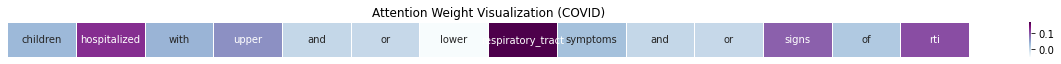

In [88]:
fig, ax = plt.subplots(figsize=(17, 1))
ax = sns.heatmap([res[0][0][0]], cmap="BuPu", annot = [text[0].split(' ')], fmt = '', linewidth=0.5)
ax.set(xlabel=None)
ax.set(xticklabels=[])
ax.set(ylabel=None)
ax.set(title='Attention Weight Visualization (COVID)')
ax.set(yticklabels=[])
ax.tick_params(bottom=False) 
ax.tick_params(left=False) 
plt.tight_layout()
plt.show()

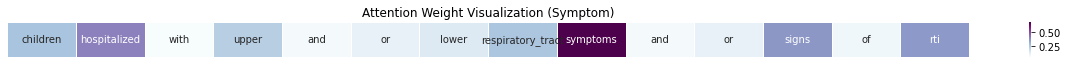

In [89]:
fig, ax = plt.subplots(figsize=(17, 1))
ax = sns.heatmap([res[0][0][1]], cmap="BuPu", annot = [text[0].split(' ')], fmt = '', linewidth=0.5)
ax.set(xlabel=None)
ax.set(xticklabels=[])
ax.set(ylabel=None)
ax.set(yticklabels=[])
ax.set(title='Attention Weight Visualization (Symptom)')
ax.tick_params(bottom=False) 
ax.tick_params(left=False) 
plt.tight_layout()
plt.show()

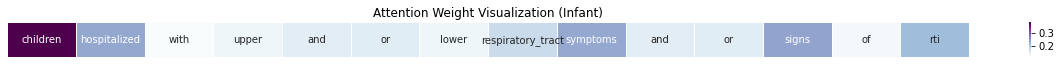

In [90]:
fig, ax = plt.subplots(figsize=(17, 1))
ax = sns.heatmap([res[0][0][2]], cmap="BuPu", annot = [text[0].split(' ')], fmt = '', linewidth=0.5)
ax.set(xlabel=None)
ax.set(xticklabels=[])
ax.set(ylabel=None)
ax.set(yticklabels=[])
ax.set(title='Attention Weight Visualization (Infant)')
ax.tick_params(bottom=False) 
ax.tick_params(left=False) 
plt.tight_layout()
plt.show()